In [1]:
import numpy as np
import pandas as pd
from osgeo import gdal
import time
import math
from sklearn.linear_model import LinearRegression
import higra as hg
import scipy.ndimage as si
from skimage import measure
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
np.random.seed(42)

In [2]:
########### sub-functions

def makeTif_np_to_matching_tif(array, tif_path, out_folder, ending, noData = None):
    ds = gdal.Open(tif_path)
    gtiff_driver = gdal.GetDriverByName('GTiff')
    file_name = tif_path.split('/')[-1].split('.')[0]
    out_ds = gtiff_driver.Create(f'{out_folder}/{file_name}{ending}',ds.RasterXSize, ds.RasterYSize, 1, gdal.GDT_Float32)
    out_ds.SetGeoTransform(ds.GetGeoTransform())
    out_ds.SetProjection(ds.GetProjection())             
    out_ds.GetRasterBand(1).WriteArray(array)
    if noData != None:
        out_ds.GetRasterBand(1).SetNoDataValue(noData)
    del out_ds

def TooCloseToBorder(numbered_array, border_limit):
    rows, cols = np.where(numbered_array==True)
    r,c = numbered_array.shape
    if any(value < border_limit for value in [np.min(rows), r - np.max(rows), np.min(cols), c - np.max(cols)]):
        return True
    
def InstSegm(extent, boundary, t_ext=0.4, t_bound=0.2):
    """
    INPUTS:
    extent : extent prediction
    boundary : boundary prediction
    t_ext : threshold for extent
    t_bound : threshold for boundary
    OUTPUT:
    instances
    """

    # Threshold extent mask
    ext_binary = np.uint8(extent >= t_ext)

    # Artificially create strong boundaries for
    # pixels with non-field labels
    input_hws = np.copy(boundary)
    input_hws[ext_binary == 0] = 1

    # Create the directed graph
    size = input_hws.shape[:2]
    graph = hg.get_8_adjacency_graph(size)
    edge_weights = hg.weight_graph(
        graph,
        input_hws,
        hg.WeightFunction.mean
    )

    tree, altitudes = hg.watershed_hierarchy_by_dynamics(
        graph,
        edge_weights
    )
    
    # Get individual fields
    # by cutting the graph using altitude
    instances = hg.labelisation_horizontal_cut_from_threshold(
        tree,
        altitudes,
        threshold=t_bound)
    
    instances[ext_binary == 0] = -1

    return instances

def get_IoUs(extent_true, extent_pred, boundary_pred, t_ext=0.4, 
             t_bound=0.2, plot=False, sample_size=0.05, border_limit=10):

    # get predicted instance segmentation
    instances_pred = InstSegm(extent_pred, boundary_pred, t_ext=t_ext, t_bound=t_bound)
    instances_pred = measure.label(instances_pred, background=-1) 
    
    # get instances from ground truth label
    # binary_true = extent_true > 0
    # instances_true = measure.label(binary_true, background=0, connectivity=1)
    instances_true = extent_true
    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(8, 4))
        ax[0].imshow(instances_true)
        ax[1].imshow(instances_pred)
        plt.show()
    
    # loop through true fields
    field_values = np.unique(instances_true)
    # here subsetting
    field_values = np.random.choice(field_values, size=int(sample_size * len(field_values)), replace=False)

    best_IoUs = []
    field_IDs = []
    field_sizes = []
    centroid_rows = []
    centroid_cols = []
    centroid_IoUS = []

    for field_value in field_values:
        if field_value == 0:
            continue # move on to next value
    
        this_field = instances_true == field_value
        # check if field is close to border and throw away if too close
        if TooCloseToBorder(this_field, border_limit):
            continue

        # calculate centroid
        this_field_centroid = np.mean(np.column_stack(np.where(this_field)),axis=0).astype(int)
        
        # fill lists with info
        centroid_rows.append(this_field_centroid[0])
        centroid_cols.append(this_field_centroid[1])
        field_IDs.append(field_value)
        field_sizes.append(np.sum(this_field))
        
        # find predicted fields that intersect with true field
        intersecting_fields = this_field * instances_pred
        intersect_values = np.unique(intersecting_fields)
        intersect_fields = np.isin(instances_pred, intersect_values[1:])
        
        if plot:
            fig, ax = plt.subplots(1, 2, figsize=(8, 4))
            ax[0].imshow(this_field)
            ax[1].imshow(intersect_fields)
            plt.show()
        
        # compute IoU for each intersecting field
        field_IoUs = []
        center_IoU = 0
        for intersect_value in intersect_values:
            if intersect_value == 0 or (len(np.unique(intersect_values)) == 1 and intersect_value == 0):
                continue # move on to next value
            
            pred_field = instances_pred == intersect_value
            union = this_field + pred_field > 0
            intersection = (this_field * pred_field) > 0
            IoU = np.sum(intersection) / np.sum(union)
            field_IoUs.append(IoU)
            # check for centroid condition
            if instances_pred[this_field_centroid[0], this_field_centroid[1]] == intersect_value:
                center_IoU = IoU
    
        # take maximum IoU - this is the IoU for this true field
        if len(field_IoUs) != 0:
            best_IoUs.append(np.max(field_IoUs))
            # fill centroid list
            centroid_IoUS.append(center_IoU)
   
    return best_IoUs, centroid_IoUS, field_IDs, field_sizes

In [3]:
########## main-function

def get_IoUs_per_Tile(tile, extent_true, extent_pred, boundary_pred, result_dir, sample_size=0.05, border_limit=10):
    print(f'Starting on tile {tile}')
    # make a dictionary for export
    k = ['tile','t_ext','t_bound', 'max_IoU', 'centroid_IoU', 'field_IDs', 'field_sizes'] #'medianIoU', 'meanIoU', 'IoU_50', 'IoU_80']
    v = [list() for i in range(len(k))]
    res = dict(zip(k, v))

    # set the parameter combinations and test combinations
    t_exts = [i/100 for i in range(10,55,5)] 
    t_bounds = [i/100 for i in range(10,55,5)]

    # loop over parameter combinations
    for t_ext in t_exts:
        for t_bound in t_bounds:
            #print('thresholds: ' + str(t_ext) + ', ' +str(t_bound))

            img_IoUs, centroid_IoUS, field_IDs, field_sizes = get_IoUs(extent_true, extent_pred, boundary_pred, t_ext=t_ext, t_bound=t_bound,
                                sample_size=sample_size ,border_limit=border_limit)
            
            for e, IoUs in enumerate(img_IoUs):
    
                res['tile'].append(tile)
                res['t_ext'].append(t_ext)
                res['t_bound'].append(t_bound)
                res['max_IoU'].append(IoUs)
                res['centroid_IoU'].append(centroid_IoUS[e])
                res['field_IDs'].append(field_IDs[e])
                res['field_sizes'].append(field_sizes[e])
    
    # export results
    df  = pd.DataFrame(data = res)
    df.to_csv(f'{result_dir}_{tile}_IoU_hyperparameter_tuning_full.csv', index=False)

In [6]:
######### prepare job-list


# create lists that will be passed on to the joblist
tile_list = []
extent_true_list = []
extent_pred_list = []
boundary_pred_list = []
result_dir_list = []

# load the predictions and labels
predictions =  '/data/fields/output/predictions/FORCE/BRANDENBURG/vrt/256_20_masked_chipsvrt.vrt' # predictions straight from GPU 
reference =  '/data/fields/IACS/Auxiliary/GSA-DE_BRB-2019_All_agromask_linecrop_prediction_extent.tif' # mask from IACS
result_dir = '/data/fields/Auxiliary/grid_search/' + predictions.split('/')[-1].split('.')[0] + '_' + reference.split('/')[-1].split('.')[0]


# load IACS reference mask and label it 
ref_ds = gdal.Open(reference)
extent_true = ref_ds.GetRasterBand(1).ReadAsArray() 
binary_true = extent_true > 0
instances_true = measure.label(binary_true, background=0, connectivity=1)

# draw a sample from instances true 
unique_IDs, counts = np.unique(instances_true, return_counts=True)
id_to_count = counts[np.searchsorted(unique_IDs, instances_true)]

# make this a function!!!
makeTif_np_to_matching_tif(id_to_count, reference, '/data/fields/IACS/Auxiliary/', 'labelled_mask.tif', int(np.max(id_to_count)))

# # tile predictions in prds --> total extent encompasses 90 Force Tiles (+ a few rows and cols that will be neglected as they are outside of study area)
# pred_ds = gdal.Open(predictions)
# rows, cols = pred_ds.RasterYSize, pred_ds.RasterXSize

# # set the number by which rows and cols will be divided --> determines the number of tiles
# slicer = 10

# row_start = [i for i in range(0, rows, math.floor(rows/slicer))]
# row_end = [i for i in range (math.floor(rows/slicer), rows, math.floor(rows/slicer))]
# row_start = row_start[:len(row_end)] 

# col_start = [i for i in range(0, cols, math.floor(cols/slicer))]
# col_end = [i for i in range (math.floor(cols/slicer), cols, math.floor(cols/slicer))]
# col_start = col_start[:len(col_end)] 

# # read in vrt in tiles
# for i in range(len(row_end)):
#     for j in range(len(col_end)):
        
#         # make identifier for tile for csv
#         tile_list.append(f'{str(i)}_{str(j)}')
#         #s ubset the prediction of fields read-in
#         extent_pred = pred_ds.GetRasterBand(1).ReadAsArray(col_start[j], row_start[i], col_end[j] - col_start[j], row_end[i] - row_start[i]) # goes into InstSegm --> image of crop probability
#         # check if prediction subset of fields actually contains data
#         if len(np.unique(extent_pred)) == 1:
#             continue
#         extent_pred_list.append(extent_pred)
#         # load predicted boundary prob subset // goes into InstSegm --> image of boundary probability
#         boundary_pred_list.append(pred_ds.GetRasterBand(2).ReadAsArray(col_start[j], row_start[i], col_end[j] - col_start[j], row_end[i] - row_start[i])) 
        
#         # load IACS reference mask and label it // goes into InstSegm --> image of crop probability
#         ref_ds = gdal.Open(reference)
#         extent_true = ref_ds.GetRasterBand(1).ReadAsArray(col_start[j], row_start[i], col_end[j] - col_start[j], row_end[i] - row_start[i]) 
        
#         binary_true = extent_true > 0
#         instances_true = measure.label(binary_true, background=0, connectivity=1)
#         extent_true_list.append(instances_true)

#         result_dir_list.append(result_dir)

# jobs = [[tile_list[i], extent_true_list[i], extent_pred_list[i], boundary_pred_list[i], result_dir_list[i], 0.001, 10]  for i in range(len(result_dir_list))]

In [ ]:
unique_IDs, counts = np.unique(instances_true, return_counts=True)
# drop background
unique_IDs = unique_IDs
counts = counts

In [4]:
binary_true = np.array([[0, 1, 1, 0],
                        [1, 1, 0, 0],
                        [0, 1, 1, 1],
                        [0, 0, 0, 0]])

# Label connected components (unique IDs for connected regions)
instances_true = measure.label(binary_true, background=0, connectivity=1)

# Get unique IDs and counts (size of each connected region)
unique_IDs, counts = np.unique(instances_true, return_counts=True)

# Create a dictionary mapping unique_IDs to counts
id_to_count = dict(zip(unique_IDs, counts))

In [8]:
replaced_instances = np.vectorize(id_to_count.get)(instances_true)
print(replaced_instances)

[[9 7 7 9]
 [7 7 9 9]
 [9 7 7 7]
 [9 9 9 9]]


In [64]:
arr = counts[1:]
#arr = arr[arr<5000]
num_bins = 20
bin_edges = np.linspace(arr.min(), arr.max(), num_bins + 1)

In [66]:
percentiles = [perc for perc in range(10,100,10)]
percentile_values = np.percentile(arr, percentiles)

# Display results
for p, value in zip(percentiles, percentile_values):
    print(f"{p}th percentile: {value}")

10th percentile: 1.0
20th percentile: 1.0
30th percentile: 3.0
40th percentile: 14.0
50th percentile: 48.0
60th percentile: 111.0
70th percentile: 240.0
80th percentile: 515.0
90th percentile: 1227.0


In [61]:
for i in range(bin_edges.shape[0] - 1):
    sub = arr[(arr > bin_edges[i]) & (arr <= bin_edges[i +1])]
    print(f'Between lowerbin: {bin_edges[i]} and upperbin {bin_edges[i +1]} are {sub.shape[0]} fields')
    

Between lowerbin: 1.0 and upperbin 250.85 are 139703 fields
Between lowerbin: 250.85 and upperbin 500.7 are 25905 fields
Between lowerbin: 500.7 and upperbin 750.55 are 14118 fields
Between lowerbin: 750.55 and upperbin 1000.4 are 9331 fields
Between lowerbin: 1000.4 and upperbin 1250.25 are 6665 fields
Between lowerbin: 1250.25 and upperbin 1500.1 are 5107 fields
Between lowerbin: 1500.1 and upperbin 1749.95 are 3855 fields
Between lowerbin: 1749.95 and upperbin 1999.8 are 3223 fields
Between lowerbin: 1999.8 and upperbin 2249.65 are 2596 fields
Between lowerbin: 2249.65 and upperbin 2499.5 are 1934 fields
Between lowerbin: 2499.5 and upperbin 2749.35 are 1683 fields
Between lowerbin: 2749.35 and upperbin 2999.2 are 1449 fields
Between lowerbin: 2999.2 and upperbin 3249.0499999999997 are 1131 fields
Between lowerbin: 3249.0499999999997 and upperbin 3498.9 are 971 fields
Between lowerbin: 3498.9 and upperbin 3748.75 are 853 fields
Between lowerbin: 3748.75 and upperbin 3998.6 are 708 f

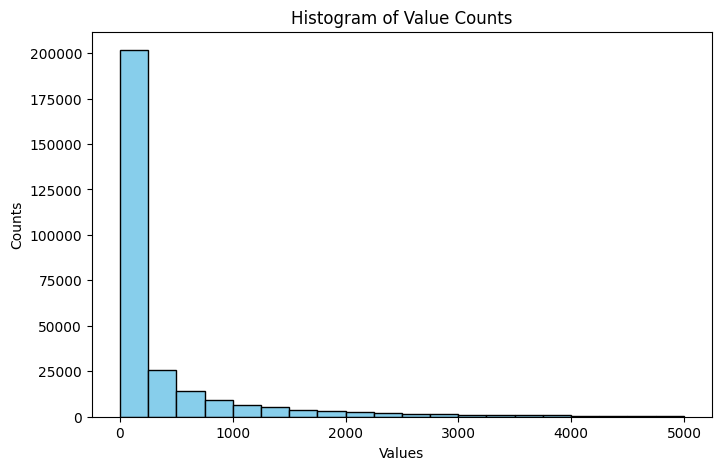

In [48]:
# Plotting histogram
plt.figure(figsize=(8, 5))
plt.hist(arr, bins=bin_edges, edgecolor='black', color='skyblue')

# Labels and title
plt.xlabel("Values")
plt.ylabel("Counts")
plt.title("Histogram of Value Counts")

# Display plot
plt.show()

In [ ]:
if __name__ == '__main__':
    starttime = time.strftime("%a, %d %b %Y %H:%M:%S", time.localtime())
    print("--------------------------------------------------------")
    print("Starting process, time:" + starttime)
    print("")

    Parallel(n_jobs=20)(delayed(get_IoUs_per_Tile)(i[0], i[1], i[2], i[3], i[4], i[5], i[6]) for i in jobs)

    print("")
    endtime = time.strftime("%a, %d %b %Y %H:%M:%S", time.localtime())
    print("--------------------------------------------------------")
    print("--------------------------------------------------------")
    print("start : " + starttime)
    print("end: " + endtime)
    print("")